## 01_gsw_tools.ipynb
---


This notebook uses the Gibbs-SeaWater (GSW) Oceanographic Toolbox containing the TEOS-10 subroutines for evaluating the thermodynamic properties of seawater. Specifically we are going to calculate: 

**1.** Absolute Salinity ($S_A$) from Argo practical salinity 

**2.** Conservative Temperature ($\theta$) from Argo in-situ temperature 

**3.** Potential Density Anomaly ($\sigma_t$) with reference pressure of 0 dbar using the calculated $S_A$ and $\theta$

Anomalies in $S_A$, $\theta$, and $\sigma_t$ are computed by removing the long-term (January 2004 – December 2020) monthly mean at each space and pressure point.

### Roemmich and Gilson Argo Climatology

The data we are using is from the updated **[Roemmich and Gilson (RG) Argo Climatology](http://sio-argo.ucsd.edu/RG_Climatology.html)** from the Scripps Instition of Oceanography. This data contains monthly ocean temperature and salinity on 58 levels from 2.5 to 2000 dbars from January 2004 through present. The RG climatology has a regular global 1 degree grid and is available as NetCDF only. It contains only data from Argo floats using optimal interpolation. This data product is described in further detail in [Roemmich and Gilson (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0079661109000160?via%3Dihub)

In [2]:
import xarray as xr
import dask 
import gsw
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [42]:
%%time
# Import the netCDF files that are downloaded when running 01_get_data.sh from the command line

data_path = '/burg/home/hs3277/mhw-2020/data/*'
dask.config.set({"array.slicing.split_large_chunks": False})
ds = xr.open_mfdataset(data_path, decode_times=False, engine='netcdf4')
dyr = ds.TIME
dates = np.arange('2004-01', '2021-08', dtype='datetime64[M]')
ds = ds.assign(TIME = dates)

CPU times: user 36 s, sys: 1min 3s, total: 1min 39s
Wall time: 1min 44s


In [43]:
def monthly_anomaly_noseason(time, t_anom, t_mean, s_anom, s_mean):
    t_tot = t_anom + t_mean
    s_tot = s_anom + s_mean
    
    t_clim = t_tot.groupby('TIME.month').mean()
    s_clim = s_tot.groupby('TIME.month').mean()
    
    t_anom_noseason = np.empty(t_tot.shape) 
    t_anom_noseason[:] = np.nan
    for i in enumerate(t_clim.month.values):
        I = np.where(time.dt.month == i[1])[0]
        t_anom_noseason[I,:,:,:] = t_tot[I,:,:,:] - t_clim[i[0],:,:,:]
    t_anom_noseason = xr.DataArray(t_anom_noseason, dims=t_tot.dims, coords=t_tot.coords) 
    
    s_anom_noseason = np.empty(s_tot.shape) 
    s_anom_noseason[:] = np.nan
    for i in enumerate(s_clim.month.values):
        I = np.where(time.dt.month == i[1])[0]
        s_anom_noseason[I] = s_tot[I,:,:,:] - s_clim[i[0],:,:,:]
    s_anom_noseason = xr.DataArray(s_anom_noseason, dims=s_tot.dims, coords=s_tot.coords) 
  
    return t_tot, s_tot, t_anom_noseason, s_anom_noseason
    

In [44]:
%%time
t_tot, s_tot, t_anom_noseason, s_anom_noseason = monthly_anomaly_noseason(ds.TIME, ds.ARGO_TEMPERATURE_ANOMALY, ds.ARGO_TEMPERATURE_MEAN, ds.ARGO_SALINITY_ANOMALY, ds.ARGO_SALINITY_MEAN)


CPU times: user 1min 39s, sys: 17min 18s, total: 18min 58s
Wall time: 19min 36s


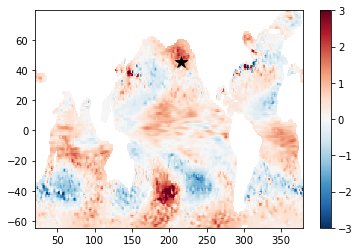

In [45]:
blob1 = t_anom_noseason.sel(TIME='2019-12-01')
plt.pcolormesh(blob1.LONGITUDE, blob1.LATITUDE, blob1[0,:,:], vmin=-3, vmax=3, cmap='RdBu_r'); plt.colorbar()
plt.plot(215.5, 45.5,'k*',ms=12)

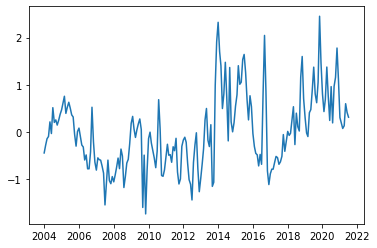

In [46]:
blob1_ts = t_anom_noseason.sel(LONGITUDE=215.5, LATITUDE=45.5)
plt.plot(t_anom_noseason.TIME,blob1_ts[:,0])

In [47]:
s_tot.load();
ds.load();

---
### **1**. Absolute Salinity ($S_A$) from Practical Salinity.

    gsw.SA_from_SP(SP, p, lon, lat)
    
Calculates Absolute Salinity from Practical Salinity. Since SP is non-negative by definition, this function changes any negative input values of SP to be zero.

**Parameters**:
- *SP* array-like Practical Salinity (PSS-78), unitless
- $p$ array-like Sea pressure (absolute pressure minus 10.1325 dbar), dbar
- $lon$ array-like Longitude, -360 to 360 degrees
- $lat$ array-like Latitude, -90 to 90 degrees

**Returns**:
- Absolute Salinity ($S_A$) array-like, g/kg Absolute Salinity

In [48]:
%%time 
SA_tot = np.empty(s_tot.shape) 
SA_tot[:] = np.nan

# Compute Absolute Salinity
for la in np.arange(0, ds.LATITUDE.shape[0]): 
    for lo in np.arange(0, ds.LONGITUDE.shape[0]): 
        SA_tot[:,:,la,lo] = gsw.SA_from_SP(s_tot[:,:,la,lo].values, ds.PRESSURE[:].values, 360-ds.LONGITUDE[lo].values, ds.LATITUDE[la].values)


CPU times: user 1min 23s, sys: 7.64 s, total: 1min 31s
Wall time: 1min 33s


---
### **2**. Conservative Temperature ($\Theta$) from in-situ temperature.
    
    gsw.CT_from_t(SA, t, p)

Calculates Conservative Temperature of seawater from in-situ temperature.

**Parameters**: 
- $S_A$ array-like Absolute Salinity, g/kg
- $t$ array-like In-situ temperature (ITS-90), degrees C
- $p$ array-like Sea pressure (absolute pressure minus 10.1325 dbar), dbar

**Returns**:
- Conservative Temperature ($\Theta$) array-like, deg C Conservative Temperature (ITS-90)



In [49]:
t_tot.load();

In [50]:
%%time
CT_tot = np.empty(t_tot.shape) 
CT_tot[:] = np.nan

for p in np.arange(0, ds.PRESSURE.shape[0]): 
    CT_tot[:,p,:,:] = gsw.CT_from_t(SA_tot[:,p,:,:], t_tot[:,p,:,:].values, ds.PRESSURE[p].values)


CPU times: user 54.8 s, sys: 38.1 s, total: 1min 32s
Wall time: 1min 33s


---
### **3**. Potential Density Anomaly ($\sigma_t$) from absolute salinity and conservative temperature

    gsw.density.sigma0(SA, CT)

Calculates potential density anomaly with reference pressure of 0 dbar, this being this particular potential density minus 1000 kg/m^3. This function has inputs of Absolute Salinity and Conservative Temperature. This function uses the computationally-efficient expression for specific volume in terms of SA, CT and p (Roquet et al., 2015).

**Parameters**:
- $S_A$ array-like Absolute Salinity, g/kg
- $CT$ array-like Conservative Temperature (ITS-90), degrees C

**Returns**:
- Potential Density Anomaly ($\sigma_t$) array-like, kg/m$^{3}$ potential density anomaly with respect to a reference pressure of 0 dbar, that is, this potential density - 1000 kg/m$^{3}$.


In [51]:
%%time 
sigmaT_tot = np.empty(t_tot.shape) 
sigmaT_tot[:] = np.nan

for p in np.arange(0, ds.PRESSURE.shape[0]): 
    sigmaT_tot[:,p,:,:] = gsw.density.sigma0(SA_tot[:,p,:,:], CT_tot[:,p,:,:])

CPU times: user 8.22 s, sys: 1min 34s, total: 1min 42s
Wall time: 1min 44s


---
**Compute anomalies in $S_A$, $\theta$, and $\sigma_t$** by removing the long-term (January 2004 – December 2020) monthly mean at each space and pressure point.

In [52]:
# Initialize numpy matrices
SA_anom = np.empty(s_tot.shape) 
SA_anom[:] = np.nan

CT_anom = np.empty(t_tot.shape) 
CT_anom[:] = np.nan

sigmaT_anom = np.empty(t_tot.shape) 
sigmaT_anom[:] = np.nan


In [53]:
for i in np.arange(1,13):
    
    I = np.where(ds.TIME.dt.month==i)[0]
    
    CT_mn = CT_tot[I,:,:,:].mean(axis=0)
    CT_anom[I,:,:,:] = CT_tot[I,:,:,:] - CT_mn
    
    SA_mn = SA_tot[I,:,:,:].mean(axis=0)
    SA_anom[I,:,:,:] = SA_tot[I,:,:,:] - SA_mn
    
    sigt_mn = sigmaT_tot[I,:,:,:].mean(axis=0)
    sigmaT_anom[I,:,:,:] = sigmaT_tot[I,:,:,:] - sigt_mn

---
**Save** the total and anomaly fields of $S_A$, $\theta$, and $\sigma_t$ to zarr

In [54]:
RG_GSW_anoms = xr.Dataset({'SA_tot': (('TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'), SA_tot),
                          'CT_tot': (('TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'), CT_tot),
                          'sigmaT_tot': (('TIME','PRESSURE', 'LATITUDE', 'LONGITUDE'), sigmaT_tot),
                          'SA_anom': (('TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'), SA_anom),
                          'CT_anom': (('TIME', 'PRESSURE', 'LATITUDE', 'LONGITUDE'), CT_anom),
                          'sigmaT_anom': (('TIME','PRESSURE', 'LATITUDE', 'LONGITUDE'), sigmaT_anom),
                          'mask': (('PRESSURE', 'LATITUDE', 'LONGITUDE'), ds.MAPPING_MASK.values)},
                         coords={'TIME': ds.TIME, 
                                 'PRESSURE': ds.PRESSURE,
                                 'LATITUDE': ds.LATITUDE,
                                 'LONGITUDE': ds.LONGITUDE})



In [56]:
RG_GSW_anoms.to_netcdf("/burg/home/hs3277/mhw-2020/data/CT_SA_sigmaT_RG09_m07_y2021.nc")